# Language Identification Hackathon

## Overview

South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and political life of the South African society.

The country is multilingual with 11 official languages, each of which is guaranteed equal status. Most South Africans are multilingual and able to speak at least two or more of the official languages.
From South African Government

With such a multilingual population, it is only obvious that our systems and devices also communicate in multi-languages.

In this challenge, you will take text which is in any of South Africa's 11 Official languages and identify which language the text is in. This is an example of NLP's Language Identification, the task of determining the natural language that a piece of text is written in.

## Importing Packages

In [1]:
!pip install contractions
!pip install scikit-plot
!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import nltk
import string
import re
from sklearn.pipeline import Pipeline

# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Train test split
from sklearn.model_selection import train_test_split

# classification models
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import MultinomialNB

import lightgbm as lgb

from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import contractions

#optimization
#Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_confusion_matrix

#Vizualization libraries
from PIL import Image
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
from sklearn.metrics import plot_roc_curve
#from wordcloud import WordCloud, ImageColorGenerator
%matplotlib inline

## Loading The Data

In [3]:
train = pd.read_csv('train_set.csv')
test = pd.read_csv('test_set.csv')

In [4]:
print('Train Info')
print('-'*40)
train.info()
print('-'*40)
print('Train data view')
train.head()

Train Info
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB
----------------------------------------
Train data view


,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


## Data Cleaning

In [5]:
def drop_blank(df):
    
#this function returns a list of indexes where there are any blank spaces
    blanks=[]
    for i, label,value in df.itertuples():
        if type(value) == str:
            if value.isspace():
                blanks.append(i)
    return blanks

In [6]:
#this is where I drop blank spaces in the train dataset
train.drop(drop_blank(train),inplace = True)

In [7]:
#this is where I drop blank spaces in the test dataset
test.drop(drop_blank(test),inplace = True)

In [8]:
def data_clean(df):

#this function will return a datframe that has been data wrangled   

    df['text'] = df['text'].apply(lambda y: contractions.fix(y))
    df['text'] = df['text'].str.replace('-',' ')
    df['text'] = df['text'].apply(TweetTokenizer().tokenize)
    df['text'] = df['text'].apply(lambda x : [token for token in x if token not in string.punctuation])
    df['text'] = df['text'].apply(lambda x: [token for token in x if token not in list(string.digits)])
    df['text'] = df['text'].apply(lambda x: [token for token in x if len(token) > 1])
    df['text'] = df['text'].apply(lambda x: [word.lower() for word in x])
    return df

In [9]:
train_clean = data_clean(train)

In [10]:
test_clean = data_clean(test)

## Creating Model Pipelines

In [11]:
#Ensuring the testing features are strings

X = train_clean['text'].str.join(' ')
y= train_clean['lang_id']
X_test = test_clean['text'].str.join(' ')

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [13]:
naive_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'char', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,3)
                            )),('naive', MultinomialNB()),])

naive_tfidf = Pipeline([('tfidf',  TfidfVectorizer(max_features=180000)),('naive', MultinomialNB()),])

#LinearSVC Clasiffiers
Lsvc_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'char', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,3)
                            )),('lsvc', LinearSVC(max_iter=100000)),])

Lsvc_tfidf = Pipeline([('tfidf', TfidfVectorizer(max_features=180000)),('svc', LinearSVC(max_iter=100000)),])

#SVC Classifiers
svc_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'char', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,3)
                            )),('SVC', SVC()),])

svc_tfidf = Pipeline([('CountVec',TfidfVectorizer(max_features=180000)),('SVC', SVC()),])

#SGD Classifiers
SGD_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'char', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,3)
                            )),('SGD', SGDClassifier()),])

SGD_tfidf = Pipeline([('CountVec',TfidfVectorizer(max_features=180000) ),('SGD', SGDClassifier()),])


## Training The Models

### Naive Bayes Classifiers

In [14]:
naive_count.fit(X_train,y_train)
naive_tfidf.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=180000)),
                ('naive', MultinomialNB())])

### Linear SVC classifiers

In [15]:
Lsvc_count.fit(X_train,y_train)
Lsvc_tfidf.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=180000)),
                ('svc', LinearSVC(max_iter=100000))])

### SVC classifiers

In [16]:
svc_count.fit(X_train,y_train)
svc_tfidf.fit(X_train,y_train)

Pipeline(steps=[('CountVec', TfidfVectorizer(max_features=180000)),
                ('SVC', SVC())])

### SGD classifiers

In [17]:
SGD_count.fit(X_train,y_train)
SGD_tfidf.fit(X_train,y_train)

Pipeline(steps=[('CountVec', TfidfVectorizer(max_features=180000)),
                ('SGD', SGDClassifier())])

### Model Evaluation

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       281
         eng       0.99      1.00      1.00       297
         nbl       1.00      1.00      1.00       327
         nso       1.00      0.99      1.00       322
         sot       1.00      1.00      1.00       307
         ssw       1.00      1.00      1.00       286
         tsn       0.99      0.99      0.99       297
         tso       1.00      1.00      1.00       253
         ven       1.00      1.00      1.00       322
         xho       0.99      0.99      0.99       313
         zul       0.99      0.99      0.99       295

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



Text(0.5, 1.0, 'Confustion Matrix for Naive Bayes Classifier with Count Vectorizer')

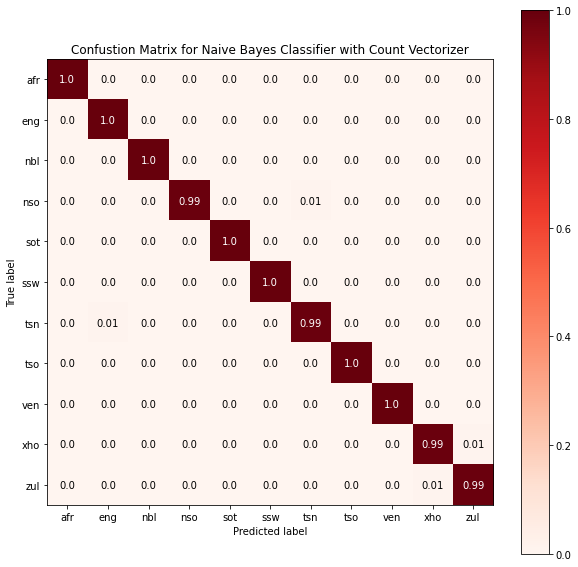

In [18]:
print(classification_report(y_val,naive_count.predict(X_val)))
plot_confusion_matrix(y_val,naive_count.predict(X_val),normalize=True, figsize=(10,10),cmap=("Reds"))
plt.title("Confustion Matrix for Naive Bayes Classifier with Count Vectorizer")

              precision    recall  f1-score   support

         afr       0.99      1.00      1.00       281
         eng       1.00      1.00      1.00       297
         nbl       1.00      1.00      1.00       327
         nso       1.00      1.00      1.00       322
         sot       1.00      1.00      1.00       307
         ssw       1.00      1.00      1.00       286
         tsn       1.00      1.00      1.00       297
         tso       1.00      1.00      1.00       253
         ven       1.00      1.00      1.00       322
         xho       1.00      1.00      1.00       313
         zul       1.00      1.00      1.00       295

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



Text(0.5, 1.0, 'Confustion Matrix for Naive Bayes Classifier with TF-IDF Vectorizer')

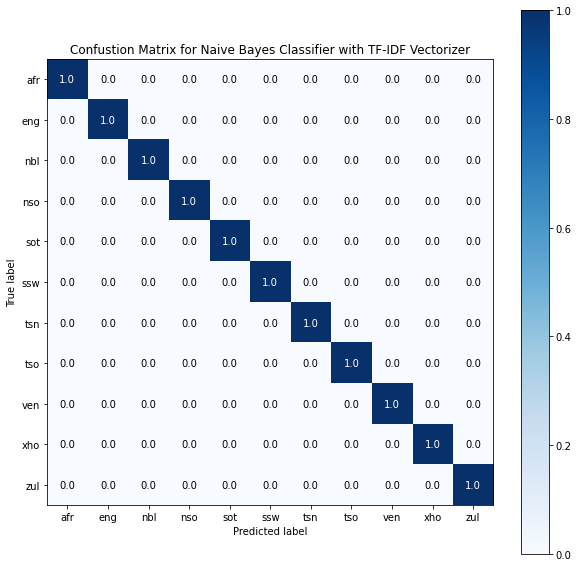

In [19]:
print(classification_report(y_val,naive_tfidf.predict(X_val)))
plot_confusion_matrix(y_val,naive_tfidf.predict(X_val),normalize=True, figsize=(10,10),cmap=("Blues"))
plt.title("Confustion Matrix for Naive Bayes Classifier with TF-IDF Vectorizer")

### Linear SVC Models

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       281
         eng       1.00      1.00      1.00       297
         nbl       1.00      0.99      1.00       327
         nso       1.00      0.99      1.00       322
         sot       1.00      1.00      1.00       307
         ssw       1.00      1.00      1.00       286
         tsn       0.99      1.00      0.99       297
         tso       1.00      1.00      1.00       253
         ven       1.00      1.00      1.00       322
         xho       1.00      1.00      1.00       313
         zul       0.99      1.00      0.99       295

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



Text(0.5, 1.0, 'Confustion Matrix for Linear SVC Classifier with Count Vectorizer')

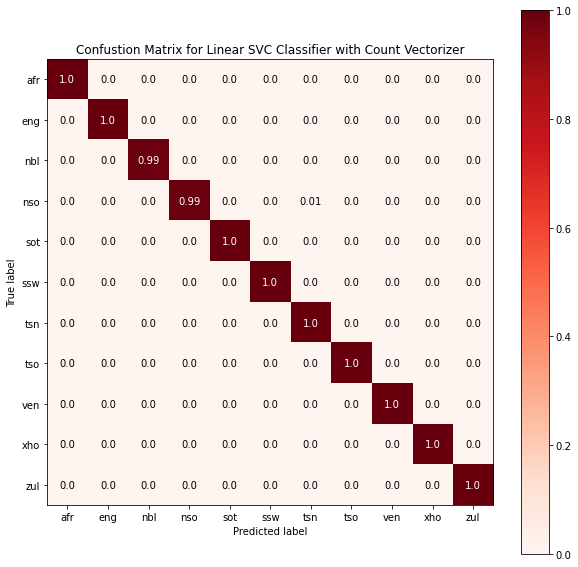

In [20]:
print(classification_report(y_val,Lsvc_count.predict(X_val)))
plot_confusion_matrix(y_val,Lsvc_count.predict(X_val),normalize=True, figsize=(10,10),cmap=("Reds"))
plt.title("Confustion Matrix for Linear SVC Classifier with Count Vectorizer")

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       281
         eng       1.00      1.00      1.00       297
         nbl       1.00      0.99      1.00       327
         nso       1.00      0.99      1.00       322
         sot       1.00      1.00      1.00       307
         ssw       0.99      1.00      0.99       286
         tsn       1.00      1.00      1.00       297
         tso       1.00      1.00      1.00       253
         ven       1.00      1.00      1.00       322
         xho       0.99      1.00      1.00       313
         zul       0.99      0.99      0.99       295

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



Text(0.5, 1.0, 'Confustion Matrix for Linear SVC Classifier with TF-IDF Vectorizer')

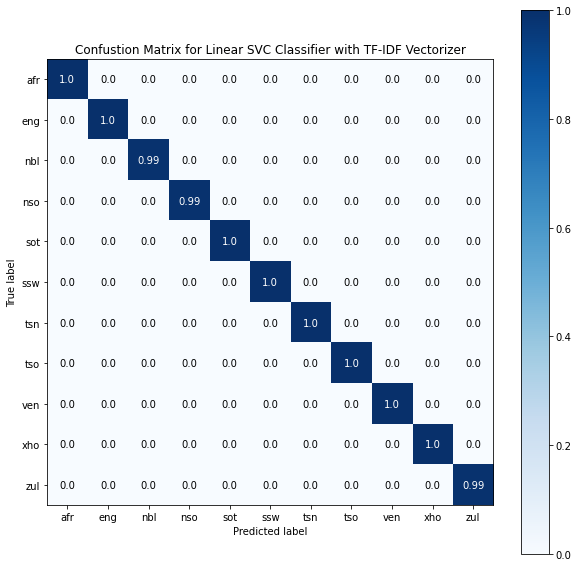

In [21]:
print(classification_report(y_val,Lsvc_tfidf.predict(X_val)))
plot_confusion_matrix(y_val,Lsvc_tfidf.predict(X_val),normalize=True, figsize=(10,10),cmap=("Blues"))
plt.title("Confustion Matrix for Linear SVC Classifier with TF-IDF Vectorizer")

### SVC Models

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       281
         eng       1.00      1.00      1.00       297
         nbl       0.99      0.98      0.99       327
         nso       1.00      0.99      0.99       322
         sot       1.00      1.00      1.00       307
         ssw       1.00      1.00      1.00       286
         tsn       0.99      1.00      0.99       297
         tso       1.00      1.00      1.00       253
         ven       1.00      1.00      1.00       322
         xho       0.98      0.99      0.99       313
         zul       0.97      0.98      0.98       295

    accuracy                           0.99      3300
   macro avg       0.99      0.99      0.99      3300
weighted avg       0.99      0.99      0.99      3300



Text(0.5, 1.0, 'Confustion Matrix for SVC Classifier Count Vectorizer')

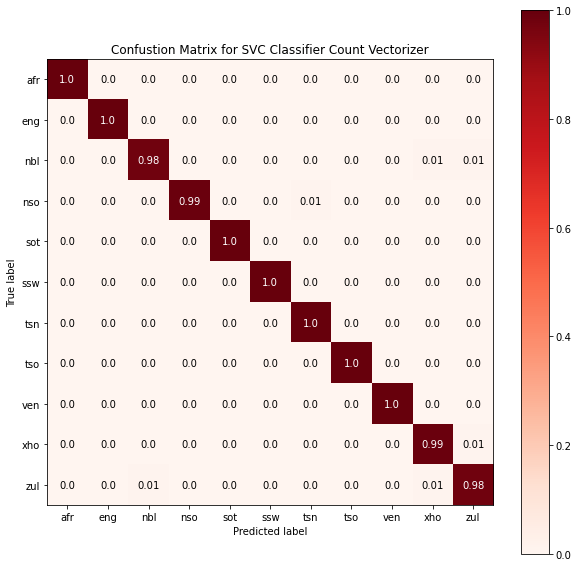

In [22]:
print(classification_report(y_val,svc_count.predict(X_val)))
plot_confusion_matrix(y_val,svc_count.predict(X_val),normalize=True, figsize=(10,10),cmap=("Reds"))
plt.title("Confustion Matrix for SVC Classifier Count Vectorizer")

              precision    recall  f1-score   support

         afr       1.00      0.99      1.00       281
         eng       1.00      0.99      0.99       297
         nbl       1.00      0.98      0.99       327
         nso       1.00      0.99      0.99       322
         sot       1.00      1.00      1.00       307
         ssw       1.00      1.00      1.00       286
         tsn       1.00      1.00      1.00       297
         tso       1.00      1.00      1.00       253
         ven       1.00      1.00      1.00       322
         xho       0.98      1.00      0.99       313
         zul       0.96      1.00      0.98       295

    accuracy                           0.99      3300
   macro avg       0.99      0.99      0.99      3300
weighted avg       0.99      0.99      0.99      3300



Text(0.5, 1.0, 'Confustion Matrix for SVC Classifier with TF-IDF Vectorizer')

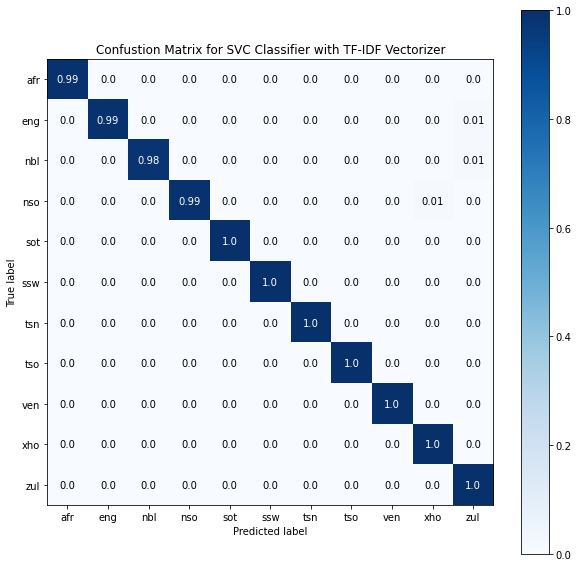

In [23]:
print(classification_report(y_val,svc_tfidf.predict(X_val)))
plot_confusion_matrix(y_val,svc_tfidf.predict(X_val),normalize=True, figsize=(10,10),cmap=("Blues"))
plt.title("Confustion Matrix for SVC Classifier with TF-IDF Vectorizer")

### Stochastic Gradient Classifiers

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       281
         eng       1.00      1.00      1.00       297
         nbl       1.00      0.99      1.00       327
         nso       1.00      0.99      1.00       322
         sot       1.00      1.00      1.00       307
         ssw       1.00      1.00      1.00       286
         tsn       0.99      1.00      0.99       297
         tso       1.00      1.00      1.00       253
         ven       1.00      1.00      1.00       322
         xho       0.99      1.00      1.00       313
         zul       0.99      1.00      0.99       295

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



Text(0.5, 1.0, 'Confustion Matrix for SGD Classifier with Count Vectorizer')

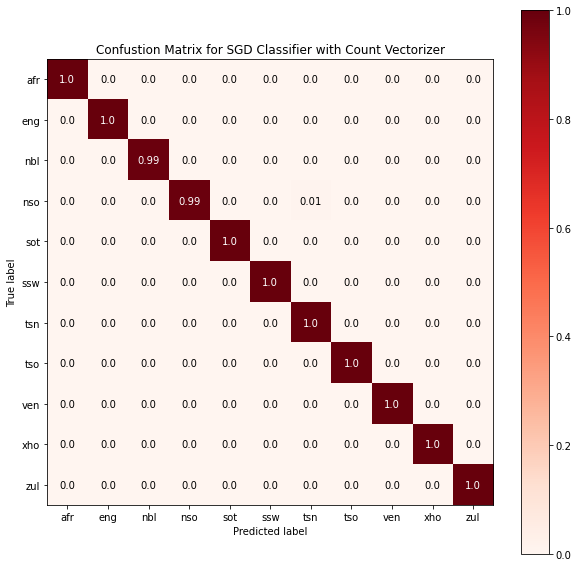

In [24]:
print(classification_report(y_val,SGD_count.predict(X_val)))
plot_confusion_matrix(y_val,SGD_count.predict(X_val),normalize=True, figsize=(10,10),cmap=("Reds"))
plt.title("Confustion Matrix for SGD Classifier with Count Vectorizer")

              precision    recall  f1-score   support

         afr       0.99      1.00      0.99       281
         eng       1.00      1.00      1.00       297
         nbl       1.00      0.99      0.99       327
         nso       1.00      0.99      1.00       322
         sot       1.00      1.00      1.00       307
         ssw       0.99      0.99      0.99       286
         tsn       1.00      1.00      1.00       297
         tso       1.00      1.00      1.00       253
         ven       1.00      1.00      1.00       322
         xho       0.99      1.00      1.00       313
         zul       0.99      0.99      0.99       295

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



Text(0.5, 1.0, 'Confustion Matrix for SGD Classifier with TF-IDF Vectorizer')

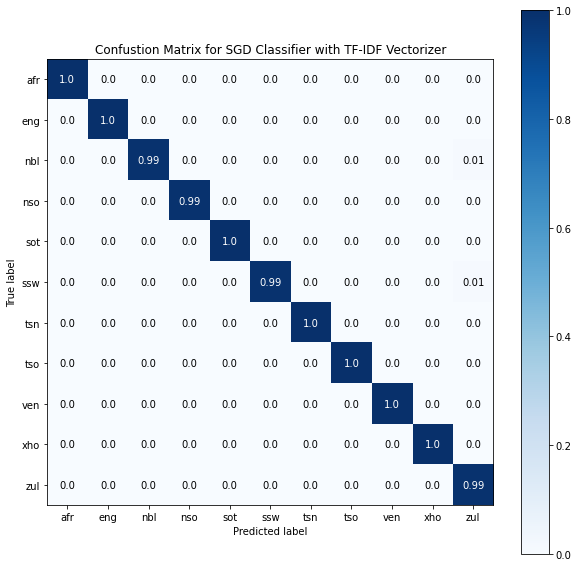

In [25]:
print(classification_report(y_val,SGD_tfidf.predict(X_val)))
plot_confusion_matrix(y_val,SGD_tfidf.predict(X_val),normalize=True, figsize=(10,10),cmap=("Blues"))
plt.title("Confustion Matrix for SGD Classifier with TF-IDF Vectorizer")

### Naive Bayes Classifier with TF-IDF Vectorizer

In [28]:
naive_tfidf.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer(max_features=180000)),
  ('naive', MultinomialNB())],
 'verbose': False,
 'tfidf': TfidfVectorizer(max_features=180000),
 'naive': MultinomialNB(),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': 180000,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 1),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'naive__alpha': 1.0,
 'naive__class_prior': None,
 'naive__fit_prior': True}

In [29]:
params = {
    'tfidf__ngram_range': [(1, 1),(2,2),(3,3),(4,4),(5,5),(6,6),(7,7),(8,8),(9,9),(10,10)],
    'naive__alpha':[0.001,0.01,0.1,1]
}
Kfold = StratifiedKFold(n_splits = 5,shuffle = True,random_state = 42)
grid = GridSearchCV(naive_tfidf,param_grid = params,n_jobs = -1,cv = Kfold,verbose =  3)

In [30]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=180000)),
                                       ('naive', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'naive__alpha': [0.001, 0.01, 0.1, 1],
                         'tfidf__ngram_range': [(1, 1), (2, 2), (3, 3), (4, 4),
                                                (5, 5), (6, 6), (7, 7), (8, 8),
                                                (9, 9), (10, 10)]},
             verbose=3)

In [31]:
model = grid.best_estimator_
print(grid.best_score_)

0.9991245791245792


              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       281
         eng       1.00      1.00      1.00       297
         nbl       1.00      1.00      1.00       327
         nso       1.00      0.99      1.00       322
         sot       0.99      1.00      1.00       307
         ssw       1.00      1.00      1.00       286
         tsn       1.00      1.00      1.00       297
         tso       1.00      1.00      1.00       253
         ven       1.00      1.00      1.00       322
         xho       1.00      1.00      1.00       313
         zul       1.00      1.00      1.00       295

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



Text(0.5, 1.0, 'Confustion Matrix for Hypertuned Naive bayes Classifier with Count Vectorizer')

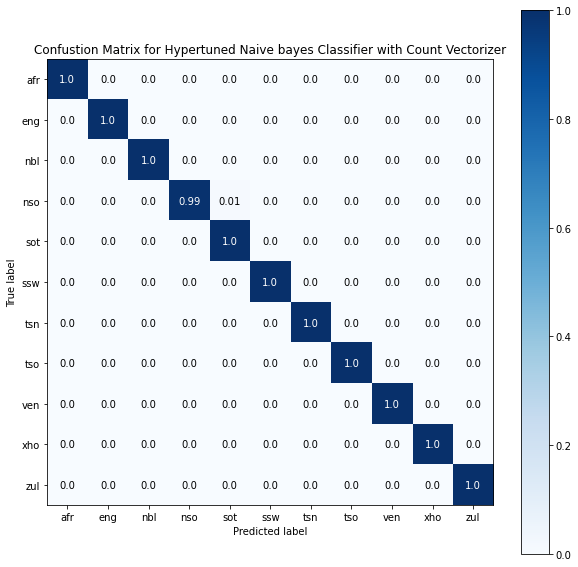

In [32]:
print(classification_report(y_val,model.predict(X_val)))
plot_confusion_matrix(y_val,model.predict(X_val),normalize = True, figsize=(10,10),cmap = ("Blues"))
plt.title("Confustion Matrix for Hypertuned Naive bayes Classifier with Count Vectorizer")

In [37]:
test['lang_id'] = model.predict(X_test)

In [38]:
test[['index','lang_id']].to_csv("submission.csv",index = False)